Imports and Constants

In [31]:
import boto3
import numpy as np
import json
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [2]:
start_date_str = '2023-05-31'
end_date_str = '2023-05-31'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

Fetching Data

In [3]:
# retrieve the IMU data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y-' + imu_k3y_id + '/accel/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and len(file.split('/')[-1].split('_')[0]) == 10
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    imu_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(imu_df)
imu_df = pd.concat(df_list, axis=0, ignore_index=True)

print(imu_df[:1])

   timestamp(epoch in sec)  lr_acc(m/s^2)  bf_acc(m/s^2)  vert_acc(m/s^2)
0             1.685488e+09       0.015745      -0.008568         0.078374


In [4]:
# retrieve the infer data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y-' + imu_k3y_id + '/infer/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and len(file.split('/')[-1].split('.')[0]) != 10
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    time_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(time_df)
time_df = pd.concat(df_list, axis=0, ignore_index=True)

print(time_df[:1])
print(time_df['imu_sw_clock(epoch)'][0] - time_df['system_clock(epoch)'][0])

   imu_sw_clock(epoch)  system_clock(epoch)  diff_sw_sys(second)  temp(C)   
0         1.685491e+09         1.685491e+09           -34.293347     64.6  \

  motion_state  
0   stationary  
-34.293346643447876


Augmenting the Data to Correct the Time Drift

In [40]:
# split up the slope segments for the time data

# drop any nan values
time_df.dropna(inplace=True)
time_df.reset_index(drop=True, inplace=True)

# identify any jumps in the data
jump_limit = 3
jump_indexes = time_df[time_df['diff_sw_sys(second)'].diff() > jump_limit].index
jump_indexes = jump_indexes.append(pd.Index([time_df.index[-1]]))

# create a list of the slope segments
segments = []
index_start = 0
for index in jump_indexes:
    seg_data = {}
    seg_data['start_timestamp'] = time_df['imu_sw_clock(epoch)'].iloc[index_start]
    seg_data['end_timestamp'] = time_df['imu_sw_clock(epoch)'].iloc[index]
    seg_data['slope'], seg_data['intercept'] = np.polyfit(time_df['system_clock(epoch)'][index_start:index], 
                                                          time_df['diff_sw_sys(second)'][index_start:index], 1)
    seg_data['offset'] = seg_data['slope'] * seg_data['start_timestamp'] + seg_data['intercept']
    segments.append(seg_data)
    index_start = index
print(segments)

[{'start_timestamp': 1685491184.4213235, 'end_timestamp': 1685512090.1271992, 'slope': -0.0015197639238619146, 'intercept': 2561513.9707173086, 'offset': -34.725353508256376}, {'start_timestamp': 1685512090.1271992, 'end_timestamp': 1685543894.7739904, 'slope': -0.0014984681949094937, 'intercept': 2525684.47368303, 'offset': -1.785508002154529}, {'start_timestamp': 1685543894.7739904, 'end_timestamp': 1685567645.689674, 'slope': -0.0014575306082568905, 'intercept': 2456730.252056171, 'offset': -1.5661374512128532}, {'start_timestamp': 1685567645.689674, 'end_timestamp': 1685568554.3660896, 'slope': -0.0011809930723514618, 'intercept': 1990642.6451554263, 'offset': -1.0673838418442756}]


In [41]:
for seg in segments:
    imu_df_seg = imu_df[(imu_df['timestamp(epoch in sec)'] >= seg['start_timestamp'])
                        & (imu_df['timestamp(epoch in sec)'] < seg['end_timestamp'])]
    imu_df.loc[imu_df_seg.index, 'correct_timestamp'] = imu_df_seg['timestamp(epoch in sec)'].apply(
        lambda x: x - (x - seg['start_timestamp']) * seg['slope'] - seg['offset'])

# drop any nan values
imu_df.dropna(inplace=True)
imu_df.reset_index(drop=True, inplace=True)

Fetching the CAN Server Data for Cross Validation

In [32]:
# retrieve the event data

# get a list of all json files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_EVENT_BUCKET, Prefix=organization_id + '/' + 'k3y-' + can_k3y_id + '/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'json'
        and len(file.split('/')[-1]) == 15
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered json files
event_dict = {}
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_EVENT_BUCKET, Key=key)
    result = json.loads(response["Body"].read().decode())
    for index in result['imu_telematics']:
        if index in event_dict:
            event_dict[index].extend(result['imu_telematics'][index])
        else:
            event_dict[index] = result['imu_telematics'][index]

In [33]:
# retrieve the CAN server data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects_v2(Bucket=CANSERVER_PARSED_BUCKET, Prefix=organization_id + '/' + 'k3y-' + can_k3y_id + '/')
all_keys = [item['Key'] for item in response.get('Contents', [])]

while response['IsTruncated']:
    response = s3_client.list_objects_v2(Bucket=CANSERVER_PARSED_BUCKET, Prefix=organization_id + '/' + 'k3y-' + can_k3y_id + '/', ContinuationToken=response['NextContinuationToken'])
    all_keys.extend([item['Key'] for item in response.get('Contents', [])])

keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_PARSED_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    can_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(can_df)
can_df = pd.concat(df_list, axis=0, ignore_index=True)

print(can_df.columns)

Index(['timestamp', 'lr_acc', 'bf_acc', 'vert_acc', 'vert_w', 'lr_w', 'bf_w',
       'speed', 'lat', 'long', 'ap_state'],
      dtype='object')


Plotting the Driving State Data for Cross Validation

27960    1.685492e+09
27961    1.685492e+09
27962    1.685492e+09
27963    1.685492e+09
27964    1.685492e+09
             ...     
41676    1.685493e+09
41677    1.685493e+09
41678    1.685493e+09
41679    1.685493e+09
41680    1.685493e+09
Name: timestamp(epoch in sec), Length: 13721, dtype: float64


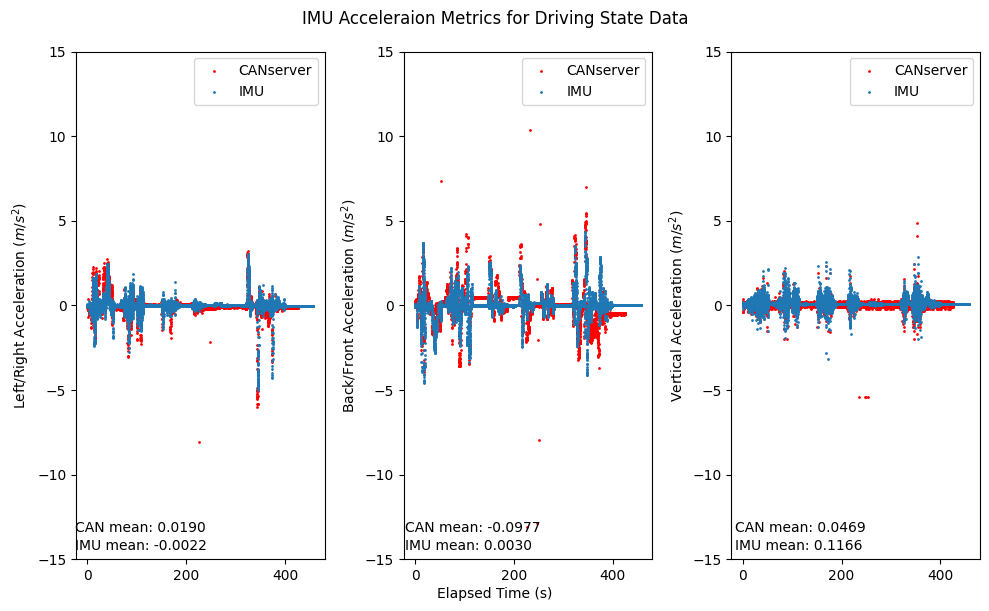

1549422    1.685544e+09
1549423    1.685544e+09
1549424    1.685544e+09
1549425    1.685544e+09
1549426    1.685544e+09
               ...     
1559821    1.685545e+09
1559822    1.685545e+09
1559823    1.685545e+09
1559824    1.685545e+09
1559825    1.685545e+09
Name: timestamp(epoch in sec), Length: 10404, dtype: float64


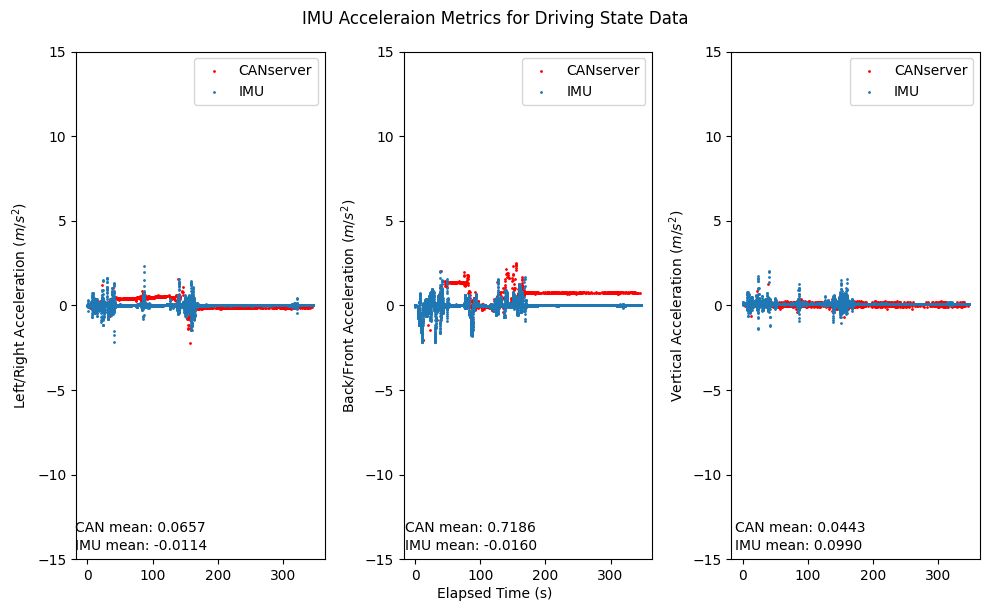

1721747    1.685550e+09
1721748    1.685550e+09
1721749    1.685550e+09
1721750    1.685550e+09
1721751    1.685550e+09
               ...     
1760878    1.685551e+09
1760879    1.685551e+09
1760880    1.685551e+09
1760881    1.685551e+09
1760882    1.685551e+09
Name: timestamp(epoch in sec), Length: 39136, dtype: float64


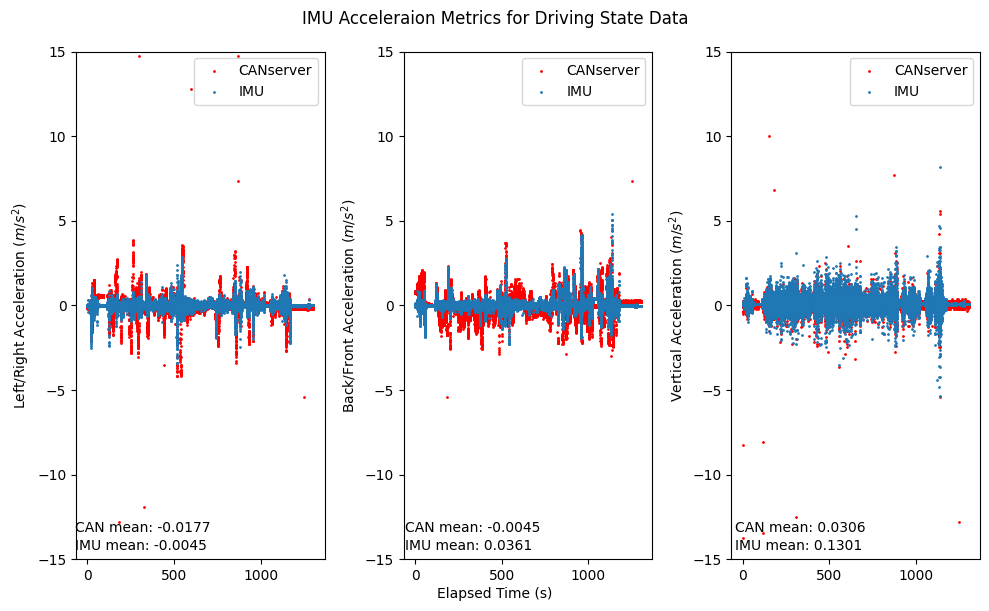

In [42]:
# plotting the IMU driving state accelerations
edge_time = 0

can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']
    dr_motion = imu_df[(imu_df['correct_timestamp'] >= dr_start_time - edge_time) 
                       & (imu_df['correct_timestamp'] <= dr_end_time + edge_time)]
    can_motion = can_df[(can_df['timestamp'] >= dr_start_time - edge_time) 
                        & (can_df['timestamp'] <= dr_end_time + edge_time)]
    
    lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
    bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
    vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
    lr_can_mean = can_motion['lr_acc'].mean()
    bf_can_mean = can_motion['bf_acc'].mean()
    vert_can_mean = can_motion['vert_acc'].mean()

    if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
        print(dr_motion['timestamp(epoch in sec)'])
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)

        lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
        bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
        vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
        lr_can_mean = can_motion['lr_acc'].mean()
        bf_can_mean = can_motion['bf_acc'].mean()
        vert_can_mean = can_motion['vert_acc'].mean()

        ax1.scatter(x=can_motion['timestamp'] - dr_start_time, y=can_motion['lr_acc'], s=1, color='red', label='CANserver')
        ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time, y=-dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
        ax1.set_ylim(-15,15)

        ax2.scatter(x=can_motion['timestamp'] - dr_start_time, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
        ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
        ax2.set_ylim(-15,15)

        ax3.scatter(x=can_motion['timestamp'] - dr_start_time, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
        ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
        ax3.set_ylim(-15,15)

        fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        fig.text(0.08,0.08,f'IMU mean: {lr_mean:.4f}')
        fig.text(0.41,0.08,f'IMU mean: {bf_mean:.4f}')
        fig.text(0.74,0.08,f'IMU mean: {vert_mean:.4f}')
        fig.text(0.08,0.11,f'CAN mean: {lr_can_mean:.4f}')
        fig.text(0.41,0.11,f'CAN mean: {bf_can_mean:.4f}')
        fig.text(0.74,0.11,f'CAN mean: {vert_can_mean:.4f}')

        ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
        ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
        ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.tight_layout()
        plt.show()

Scratch Work

In [18]:
# dt_object = datetime.datetime.fromtimestamp(imu_df['timestamp(epoch in sec)'].iloc[-2])
dt_object = datetime.datetime.fromtimestamp(time_df['imu_sw_clock(epoch)'].iloc[-1])
print(dt_object.strftime('%Y-%m-%d %H:%M:%S'))

2023-05-31 14:29:14


In [6]:
print(imu_df['timestamp(epoch in sec)'][107654])
print(time_df['imu_sw_clock(epoch)'][0])
print('')
print(imu_df['timestamp(epoch in sec)'][108684])
print(time_df['system_clock(epoch)'][0])

1685491184.4213235
1685491184.4213235

1685491218.7097433
1685491218.7146702


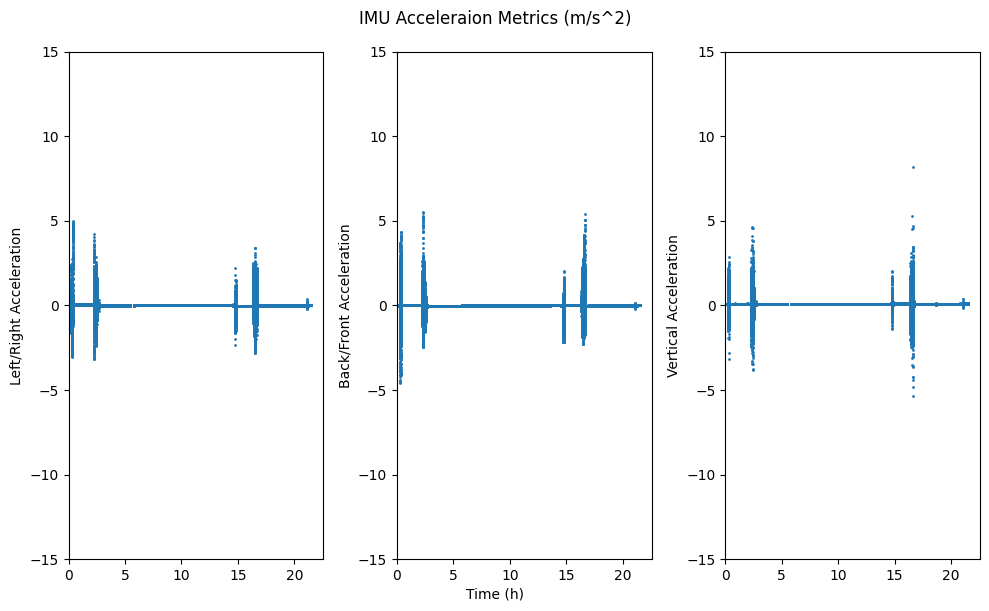

In [28]:
# plot the imu data

# plot the IMU data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
start_time = imu_df['timestamp(epoch in sec)'].min()

fig.set_size_inches(10,6)
ax1.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)
ax1.set_xlim(left=0)
ax2.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)
ax2.set_xlim(left=0)
ax3.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)
ax3.set_xlim(left=0)

fig.suptitle("IMU Acceleraion Metrics (m/s^2)")
fig.text(0.5, 0.0, 'Time (h)', ha='center')

ax1.set_ylabel("Left/Right Acceleration")
ax2.set_ylabel("Back/Front Acceleration")
ax3.set_ylabel("Vertical Acceleration")

plt.tight_layout()
plt.show()